In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

In [ ]:
df = pd.read_csv('Sleep_Efficiency.csv', index_col='ID')
df.columns

Index(['Age', 'Gender', 'Bedtime', 'Wakeup time', 'Sleep duration',
       'Sleep efficiency', 'REM sleep percentage', 'Deep sleep percentage',
       'Light sleep percentage', 'Awakenings', 'Caffeine consumption',
       'Alcohol consumption', 'Smoking status', 'Exercise frequency'],
      dtype='object')

### First Observation

Here we look at the data, for better understanding.

In [ ]:
pd.DataFrame(df.nunique(),columns=['#unique values'])

,#unique values
Age,61
Gender,2
Bedtime,424
Wakeup time,434
Sleep duration,9
Sleep efficiency,50
REM sleep percentage,13
Deep sleep percentage,29
Light sleep percentage,29
Awakenings,5


In [ ]:
pd.DataFrame(df['Sleep efficiency'].describe())

,Sleep efficiency
count,452.000000
mean,0.788916
std,0.135237
min,0.500000
25%,0.697500
50%,0.820000
75%,0.900000
max,0.990000


In [ ]:
pd.DataFrame(df['Light sleep percentage'].describe())

,Light sleep percentage
count,452.000000
mean,24.561947
std,15.313665
min,7.000000
25%,15.000000
50%,18.000000
75%,32.500000
max,63.000000


In [ ]:
pd.DataFrame(df['Deep sleep percentage'].describe())

,Deep sleep percentage
count,452.000000
mean,52.823009
std,15.654235
min,18.000000
25%,48.250000
50%,58.000000
75%,63.000000
max,75.000000


In [ ]:
pd.DataFrame(df['REM sleep percentage'].describe())

,REM sleep percentage
count,452.000000
mean,22.615044
std,3.525963
min,15.000000
25%,20.000000
50%,22.000000
75%,25.000000
max,30.000000


And here we plot the histograms for the features we found interesting, trying to understand their distribution.

<Axes: xlabel='Sleep efficiency', ylabel='Count'>

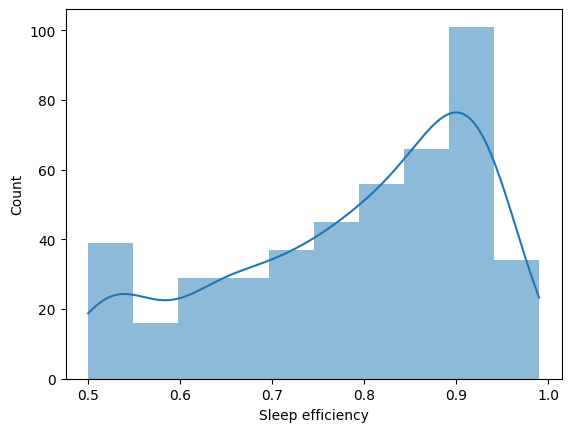

In [ ]:
sns.histplot(df['Sleep efficiency'], kde=True, edgecolor='none')

As we can see, the distribution is bounded by 1, and its most densed part is somewhere near 1, so it fits to the Weibull distribution(at least in visual way).

<Axes: xlabel='Light sleep percentage', ylabel='Count'>

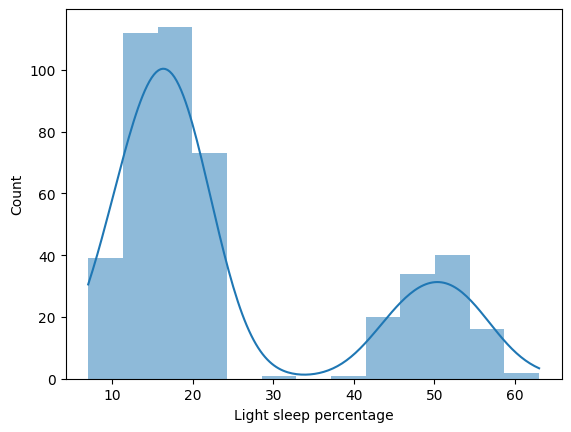

In [ ]:
sns.histplot(df['Light sleep percentage'], kde=True, edgecolor='none')

<Axes: xlabel='Deep sleep percentage', ylabel='Count'>

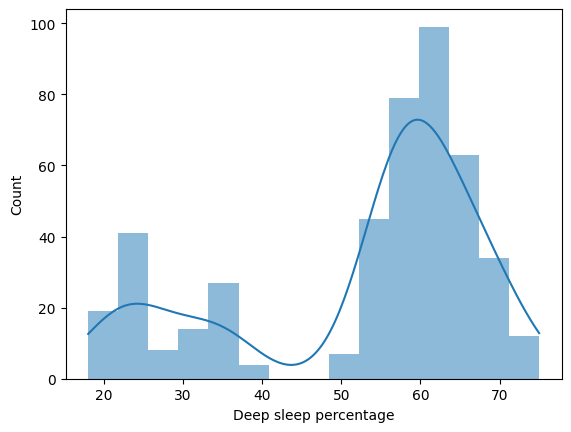

In [ ]:
sns.histplot(df['Deep sleep percentage'], kde=True, edgecolor='none')

The histograms of Deep sleep percentage and Light sleep percentage can point out a relation between the two features. It seems almost like a mirror reflection.

<Axes: xlabel='REM sleep percentage', ylabel='Count'>

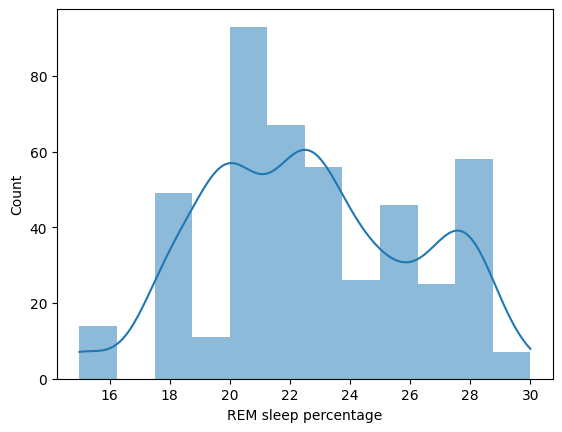

In [ ]:
sns.histplot(df['REM sleep percentage'], kde=True, edgecolor='none')

Here we see that from the mentioned features the REM sleep percentage feature is the closest to normality.

### Normality check function
This function will help us later.

In [ ]:
from scipy import stats
def check_normality(df, threshold=30):
    n = len(df)
    if n <= threshold:
        test_name = "Shapiro-Wilk"
        statistic, p_value = stats.shapiro(df)
    else:
        test_name = "Kolmogorov-Smirnov"
        statistic, p_value = stats.kstest(df, 'norm', args=(np.mean(df), np.std(df)))

    print("p value:%.4f" % p_value)
    if p_value <0.05:
        print("Reject null hypothesis >> The data is not normally distributed")
    else:
        print("Fail to reject null hypothesis >> The data is normally distributed")

## Alcohol Consumption Influence

In [ ]:
df['Alcohol consumption'].value_counts()

,count
Alcohol consumption,
0.0,246
1.0,54
3.0,48
2.0,37
5.0,30
4.0,23


There are missing values.

In [ ]:
l = df['Alcohol consumption'].loc[df['Alcohol consumption'] >3].index

In [ ]:
m = np.array([])
for i in l:
  m = np.append(m, df['Sleep efficiency'][i])
m.mean()

0.6894339622641509

The mean over the whole data is: 0.788916


## REM Sleep Percentage

In [ ]:
df = df.dropna(subset=['REM sleep percentage', 'Alcohol consumption'])

Our Null Hypothesis is that the REM sleep percentage is equall between those who cunsume a lot of alcohol(over 2 glasses), those who dont consume so much(not over 2 glasses) and those who dont consume alcohol at all. We hold the same equality statement on the Sleep efficiency of those groups.

In [ ]:
df[['Alcohol consumption','REM sleep percentage']].groupby(['Alcohol consumption'], as_index=False).mean()

,Alcohol consumption,REM sleep percentage
0,0.0,22.764228
1,1.0,22.351852
2,2.0,22.297297
3,3.0,23.770833
4,4.0,20.956522
5,5.0,21.966667


In [ ]:
clean = df['REM sleep percentage'].loc[df['Alcohol consumption']==0].to_numpy()
regular = df['REM sleep percentage'].loc[(df['Alcohol consumption']>0) & (df['Alcohol consumption']<3)].to_numpy()
drunk = df['REM sleep percentage'].loc[df['Alcohol consumption']>=3].to_numpy()

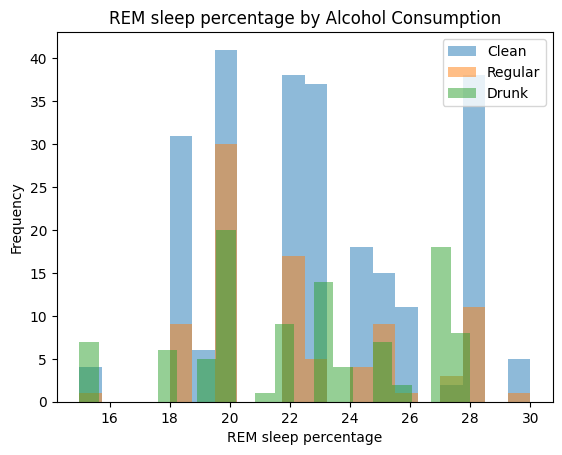

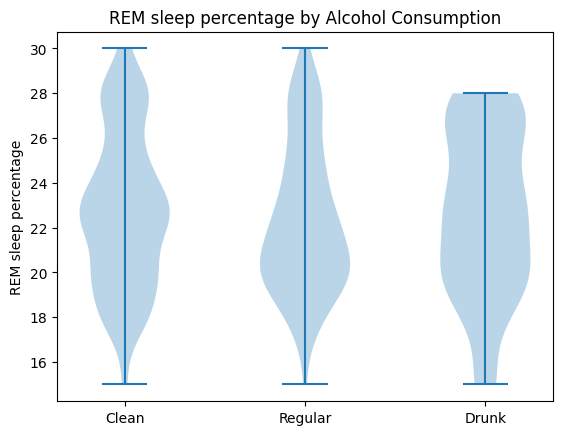

In [ ]:
import matplotlib.pyplot as plt

# Histograms
plt.hist(clean, bins=20, alpha=0.5, label='Clean')
plt.hist(regular, bins=20, alpha=0.5, label='Regular')
plt.hist(drunk, bins=20, alpha=0.5, label='Drunk')
plt.legend(loc='upper right')
plt.xlabel('REM sleep percentage')
plt.ylabel('Frequency')
plt.title('REM sleep percentage by Alcohol Consumption')
plt.show()

# Violin Plots
data = [clean, regular, drunk]
labels = ['Clean', 'Regular', 'Drunk']
plt.xticks([1, 2, 3], labels)
plt.violinplot(data)
plt.ylabel('REM sleep percentage')
plt.title('REM sleep percentage by Alcohol Consumption')
plt.show()


As we can see, the violin plot of the drunk group is very similar to a bottle turned upside down.

Here we already can see that its not going to be easy to reject the null hypothesis.

In [ ]:
check_normality(clean)
check_normality(regular)
check_normality(drunk)

p value:0.0012
Reject null hypothesis >> The data is not normally distributed
p value:0.0009
Reject null hypothesis >> The data is not normally distributed
p value:0.0350
Reject null hypothesis >> The data is not normally distributed


In [ ]:
# mann - whitney test
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(drunk, regular)
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(clean, regular)
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(drunk, clean)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=4867.500, p=0.475
Statistics=12160.500, p=0.218
Statistics=12225.500, p=0.815


The p-values are high, so unfortunately, we did not succeed to reject the null hypothesis, saying that the means are equal.

## Sleep Efficiency

Now we will examine the hypothesis on the relation between alcohol consumption to the sleep efficiency.

In [ ]:
df[['Alcohol consumption','Sleep efficiency']].groupby(['Alcohol consumption'], as_index=False).mean()

,Alcohol consumption,Sleep efficiency
0,0.0,0.832033
1,1.0,0.803889
2,2.0,0.671351
3,3.0,0.750417
4,4.0,0.685217
5,5.0,0.692667


In [ ]:
clean = df['Sleep efficiency'].loc[df['Alcohol consumption']==0].to_numpy()
regular = df['Sleep efficiency'].loc[(df['Alcohol consumption']>0) & (df['Alcohol consumption']<3)].to_numpy()
drunk = df['Sleep efficiency'].loc[df['Alcohol consumption']>=3].to_numpy()

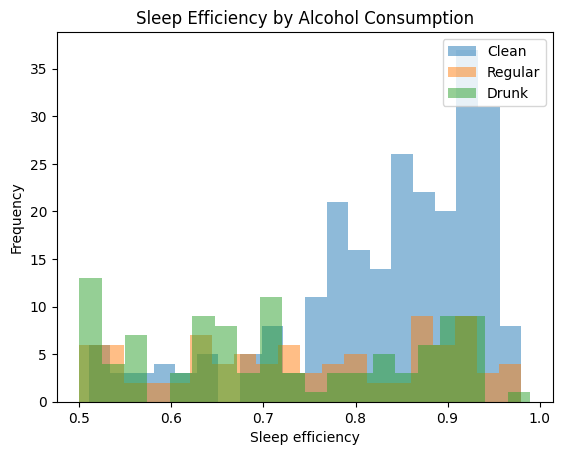

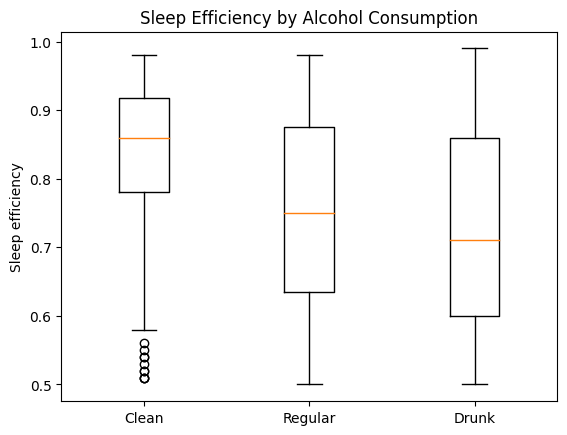

In [ ]:
# Histograms
plt.hist(clean, bins=20, alpha=0.5, label='Clean')
plt.hist(regular, bins=20, alpha=0.5, label='Regular')
plt.hist(drunk, bins=20, alpha=0.5, label='Drunk')
plt.legend(loc='upper right')
plt.xlabel('Sleep efficiency')
plt.ylabel('Frequency')
plt.title('Sleep Efficiency by Alcohol Consumption')
plt.show()

# Box Plots
data = [clean, regular, drunk]
labels = ['Clean', 'Regular', 'Drunk']

plt.boxplot(data, labels=labels)
plt.ylabel('Sleep efficiency')
plt.title('Sleep Efficiency by Alcohol Consumption')
plt.show()

Here we can see a clear gap between the clean group median to the regular group median. hopefully, we will reject the null hypothesis this time.

In [ ]:
check_normality(clean)
check_normality(regular)
check_normality(drunk)

p value:0.0026
Reject null hypothesis >> The data is not normally distributed
p value:0.1211
Fail to reject null hypothesis >> The data is normally distributed
p value:0.2190
Fail to reject null hypothesis >> The data is normally distributed


In [ ]:
# mann - whitney test
stat, p = mannwhitneyu(drunk, regular)
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(clean, regular)
print('Statistics=%.3f, p=%.3f' % (stat, p))
stat, p = mannwhitneyu(drunk, clean)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=4022.000, p=0.136
Statistics=14927.000, p=0.000
Statistics=6829.000, p=0.000


We succeeded to reject the null hypothesis, saying that the means are equal.

### The connection between Sleep efficiency and Deep sleep percentage

Here we will use K-means to ilustrate the connection between Sleep efficiency and Deep sleep percentage.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Inertia: 176.0600401665068
Silhouette Score: 0.7251181685987479


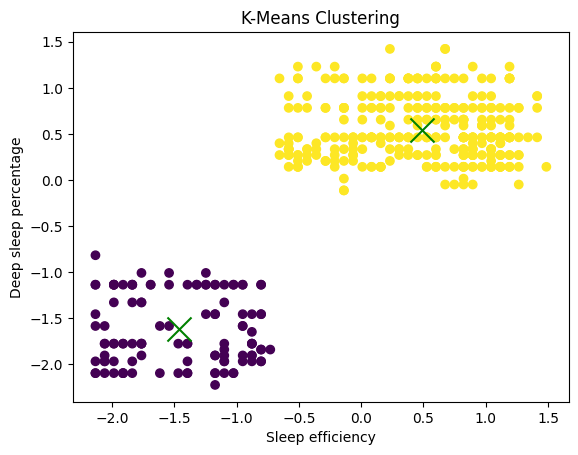

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = df[['Sleep efficiency', 'Deep sleep percentage']]
X_scaled = (X - X.mean()) / X.std()
# Train the K-Means model
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)

# Predict the cluster labels
labels = kmeans.predict(X_scaled)

# Evaluate the model
inertia = kmeans.inertia_
silhouette_avg = silhouette_score(X_scaled, labels)

print(f"Inertia: {inertia}")
print(f"Silhouette Score: {silhouette_avg}")

# Plot the clusters (only for 2D visualization)
plt.scatter(X_scaled['Sleep efficiency'], X_scaled['Deep sleep percentage'], c=labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='green', marker='x')
plt.xlabel('Sleep efficiency')
plt.ylabel('Deep sleep percentage')
plt.title('K-Means Clustering')
plt.show()

Here we check the correlation between the two.

In [ ]:
# pearson
from scipy.stats import pearsonr
corr, p = pearsonr(df['Sleep efficiency'], df['Deep sleep percentage'])
print('Pearsons correlation coefficient: %.3f' % corr)

# RPB
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df['Sleep efficiency'], df['Deep sleep percentage'])
print('R-squared value: %.3f' % r_value**2)

Pearsons correlation coefficient: 0.788
R-squared value: 0.621


## Caffeine Consumption Influence

In [ ]:
df['Caffeine consumption'].value_counts()

,count
Caffeine consumption,
0.0,204
50.0,103
25.0,78
75.0,23
200.0,4
100.0,1


The units are m-grams.

In [ ]:
df = df.dropna(subset=['Caffeine consumption'])

Our Null Hypothesis is that the REM sleep percentage is equall between those who cunsume a lot of caffeine(over 50 mg) and those who dont consume so much(not over 50 mg).
We hold the same equality statement on the Sleep efficiency of those groups.

### REM sleep percentage

In [ ]:
df[['Caffeine consumption','REM sleep percentage']].groupby(['Caffeine consumption'], as_index=False).mean()

,Caffeine consumption,REM sleep percentage
0,0.0,22.406863
1,25.0,21.948718
2,50.0,23.776699
3,75.0,22.347826
4,100.0,20.000000
5,200.0,21.500000


In [ ]:
low = df['REM sleep percentage'].loc[df['Caffeine consumption']<=50].to_numpy()
high = df['REM sleep percentage'].loc[df['Caffeine consumption']>50].to_numpy()

In [ ]:
check_normality(low)
check_normality(high)

p value:0.0000
Reject null hypothesis >> The data is not normally distributed
p value:0.0932
Fail to reject null hypothesis >> The data is normally distributed


In [ ]:
# mann - whitney test
stat, p = mannwhitneyu(low, high)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=5575.500, p=0.759


The p-value is high, so unfortunately, we did not succeed to reject the null hypothesis, saying that the means are equal.

### Sleep efficiency

In [ ]:
df[['Caffeine consumption','Sleep efficiency']].groupby(['Caffeine consumption'], as_index=False).mean()

,Caffeine consumption,Sleep efficiency
0,0.0,0.785735
1,25.0,0.802436
2,50.0,0.770485
3,75.0,0.842609
4,100.0,0.900000
5,200.0,0.882500


In [ ]:
low = df['Sleep efficiency'].loc[df['Caffeine consumption']<=50].to_numpy()
high = df['Sleep efficiency'].loc[df['Caffeine consumption']>50].to_numpy()

In [ ]:
check_normality(low)
check_normality(high)

p value:0.0000
Reject null hypothesis >> The data is not normally distributed
p value:0.0000
Reject null hypothesis >> The data is not normally distributed


In [ ]:
# mann - whitney test
stat, p = mannwhitneyu(low, high)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=3728.000, p=0.006


We succeeded to reject the null hypothesis, saying that the means are equal.

## Exercise Frequency - Influence

In [ ]:
df['Exercise frequency'].value_counts()

,count
Exercise frequency,
3.0,121
0.0,113
1.0,82
2.0,46
4.0,38
5.0,7


In [ ]:
df = df.dropna(subset=['Exercise frequency'])

### REM sleep percentage

Our Null Hypothesis is that the REM sleep percentage is equall between those who dont do a lot of exercise(0-1 times a week) and the more active group(2 times a week or more). We hold the same equality statement on the Sleep efficiency of those groups.

In [ ]:
df[['Exercise frequency','REM sleep percentage']].groupby(['Exercise frequency'], as_index=False).mean()

,Exercise frequency,REM sleep percentage
0,0.0,21.893805
1,1.0,23.804878
2,2.0,21.586957
3,3.0,23.347107
4,4.0,22.105263
5,5.0,21.714286


In [ ]:
low = df['REM sleep percentage'].loc[df['Exercise frequency']<=1].to_numpy()
high = df['REM sleep percentage'].loc[df['Exercise frequency']>1].to_numpy()

In [ ]:
check_normality(low)
check_normality(high)

p value:0.0000
Reject null hypothesis >> The data is not normally distributed
p value:0.0000
Reject null hypothesis >> The data is not normally distributed


In [ ]:
# mann - whitney test
stat, p = mannwhitneyu(low, high)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=20763.000, p=0.937


The p-value is high, so unfortunately, we did not succeed to reject the null hypothesis, saying that the means are equal.

### Sleep efficiency

In [ ]:
df[['Exercise frequency','Sleep efficiency']].groupby(['Exercise frequency'], as_index=False).mean()

,Exercise frequency,Sleep efficiency
0,0.0,0.747080
1,1.0,0.771951
2,2.0,0.811739
3,3.0,0.798760
4,4.0,0.889474
5,5.0,0.844286


In [ ]:
low = df['Sleep efficiency'].loc[df['Exercise frequency']<=1].to_numpy()
high = df['Sleep efficiency'].loc[df['Exercise frequency']>1].to_numpy()

In [ ]:
check_normality(low)
check_normality(high)

p value:0.0658
Fail to reject null hypothesis >> The data is normally distributed
p value:0.0000
Reject null hypothesis >> The data is not normally distributed


In [ ]:
# mann - whitney test
stat, p = mannwhitneyu(low, high)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=14784.500, p=0.000


We succeeded to reject the null hypothesis, saying that the means are equal.

To verify our great p-value score, we will plot the two groups to see visualy the difference.

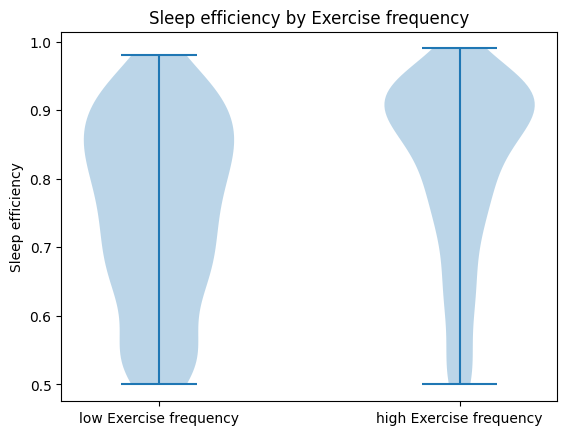

In [ ]:
# Violin Plots
data = [low, high]
labels = ['low Exercise frequency', 'high Exercise frequency']
plt.xticks([1, 2], labels)
plt.violinplot(data)
plt.ylabel('Sleep efficiency')
plt.title('Sleep efficiency by Exercise frequency')
plt.show()

Now we will check the probability for Type 2 Error. Since our groups are not normally distributed, we have to do simulations for calculating the power and beta (probability for type 2 error).

In [ ]:
import numpy as np
import scipy.stats as stats

num_simulations = 10000
alpha = 0.05

# function that do simulations
def simulate_power(low, high, alpha=0.05, num_simulations=10000):
    np.random.seed(42)
    count = 0

    for _ in range(num_simulations):
        sample1 = np.random.choice(low, size=len(low), replace=True)
        sample2 = np.random.choice(high, size=len(high), replace=True)
        stat, p_value = stats.mannwhitneyu(sample1, sample2, alternative='two-sided')

        if p_value < alpha:
            count += 1

    power = count / num_simulations
    beta = 1 - power
    return power, beta

# calculate power and beta
power, beta = simulate_power(low, high, alpha=alpha, num_simulations=num_simulations)

print(f"the Power is: {power:.4f}")
print(f"the probability for type two error (beta) is: {beta:.4f}")

the Power is: 0.9986
the probability for type two error (beta) is: 0.0014


### Conclusion

For all the features that we checked, we saw the influence on the Sleep efficiency. The different groups that we examined differ in their medians(that's what Mann-Whitney test compares).
On the other hand, for the ERM Sleep percentage, we were unable to draw clear conclusions.

### Logistic Regression

In [ ]:
# linear regression to predict sleep efficiency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df[['Exercise frequency', 'Caffeine consumption', 'Alcohol consumption']]
scaler = StandardScaler()
X = scaler.fit_transform(X)
bins = [0, 0.86, 1]
labels = [0, 1]
y = pd.cut(df['Sleep efficiency'], bins=bins, labels=labels)

# partition for train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# creating a linear regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# prediction on the test data
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7804878048780488
Confusion Matrix:
[[45  5]
 [13 19]]


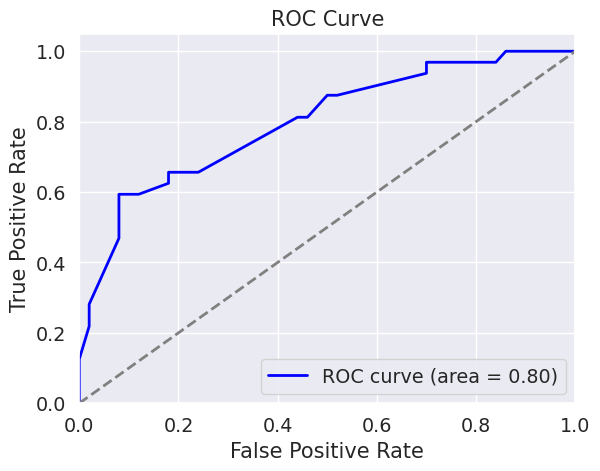

In [ ]:
from sklearn.metrics import roc_curve, auc
# ROC Curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In 78% of the guesses the model was correct. The classification is not perfect, but this is a satisfying result knowing the wide distributions we saw above.  

Here we will compute Confidence interval for the proportion - bounds telling us in Confidence of 95% how many people from a sample sleep well(>0.86 sleep efficiency).

In [ ]:
p_hat = y.value_counts()[1] / len(y)

conf_int = sm.stats.proportion_confint(y.value_counts()[1], len(y), alpha=0.05, method='normal')

print(f'The proportion is: {p_hat:.3f}')
print(f'Confidence interval in confidence level of 95% is: {conf_int}')

The proportion is: 0.396
Confidence interval in confidence level of 95% is: (0.34807265303209395, 0.4430821381226972)


Now we want to compute Confidence interval for the "low" set - people who work out once a week at most. As we saw above this data is normally distributed.

In [ ]:
# calculating mean and std of sleep efficiency for the low group
mean_sleep_efficiency = low.mean()
std_sleep_efficiency = low.std(ddof=1)

# define confidence level of 0.95
confidence_level = 0.95

n = len(low)

# calculating the critical t value
t_critical = stats.t.ppf((1 + confidence_level) / 2, df=n-1)

# calculating the standart error
standard_error = std_sleep_efficiency / np.sqrt(n)

# calculating the confidence interval
margin_of_error = t_critical * standard_error
confidence_interval = (mean_sleep_efficiency - margin_of_error, mean_sleep_efficiency + margin_of_error)

print(f"Mean Sleep Efficiency: {mean_sleep_efficiency:.2f}")
print(f"Confidence interval in confidence level of 95% is: ({confidence_interval[0]:.2f} , {confidence_interval[1]:.2f})")

Mean Sleep Efficiency: 0.76
Confidence interval in confidence level of 95% is: (0.74 , 0.78)


In [ ]:
# pearson correlation matrix
cm = df[['Exercise frequency', 'Caffeine consumption', 'Alcohol consumption', 'Sleep efficiency', 'REM sleep percentage', 'Light sleep percentage', 'Deep sleep percentage']].corr()

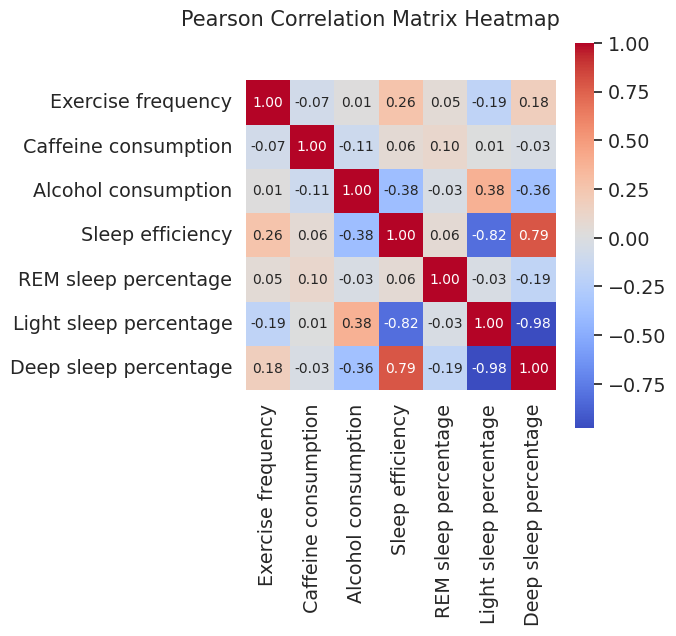

In [ ]:
cols = ['Exercise frequency', 'Caffeine consumption', 'Alcohol consumption', 'Sleep efficiency', 'REM sleep percentage', 'Light sleep percentage', 'Deep sleep percentage']
sns.set(font_scale=1.25)
plt.figure(figsize=(5, 5))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols, xticklabels=cols, cmap='coolwarm')
plt.title('Pearson Correlation Matrix Heatmap         \n\n')
plt.show()

We can see the connection here between Sleep efficiency to the main features we examined(except caffeine consumption). This stands in contrast to the low correlations shown above between REM sleep percentage and those features.

Another thing we can see here is the strong correlation between Sleep efficiency and Deep sleep percentage.

### Conclusions

Our analysis demonstrated that lifestyle factors such as alcohol consumption, caffeine intake, and physical activity levels have a significant impact on sleep efficiency. Specifically, by looking at the graphs of the distributions we can assess that higher levels of alcohol consumption were associated with reduced sleep efficiency, while increased physical activity was linked to improved sleep efficiency. As shown above, there is strong correlation between sleep efficiency and deep sleep percentage, so we expect that the features we examined will affect the deep sleep percentage as well. These findings align with existing literature that suggests these behaviors influence sleep quality and overall health.
However, our investigation into the effects of these same factors on REM sleep percentage did not yield statistically significant results. The data did not provide strong evidence to suggest that alcohol, caffeine, or physical activity levels significantly alter REM sleep percentage. This suggests that while these lifestyle factors do impact overall sleep quality, their effects on specific stages of sleep, such as REM, may be more nuanced and potentially influenced by other variables not captured in this study.
These conclusions underscore the importance of considering lifestyle choices when examining person's sleep health. Further research is needed to better understand the complex relationships between lifestyle behaviors and different stages of sleep.
